# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time
#plt.style.use('ggplot')

/home/mkim7/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


In [2]:
%matplotlib inline

In [3]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.decomposition import PCA

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
# import sys
# sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/simplesc')
# import scme, utils

In [8]:
data_path = '/data/parameter_estimation/interferon_data/20200324/'

### Perform some basic filtering

In [9]:
adata = sc.read(data_path + 'interferon.h5ad')
adata = adata[:, adata.var.index.map(lambda x: x[:2] != 'HB')]

In [10]:
adata.obs.cell.value_counts()

CD4 T cells          12033
CD14+ Monocytes      6447 
B cells              2880 
CD8 T cells          2634 
NK cells             2330 
FCGR3A+ Monocytes    1914 
Dendritic cells      472  
Megakaryocytes       346  
nan                  9    
Name: cell, dtype: int64

In [11]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

Trying to set attribute `.obs` of view, making a copy.


... storing 'ind' as categorical
... storing 'stim' as categorical
... storing 'cluster' as categorical
... storing 'cell' as categorical
... storing 'multiplets' as categorical


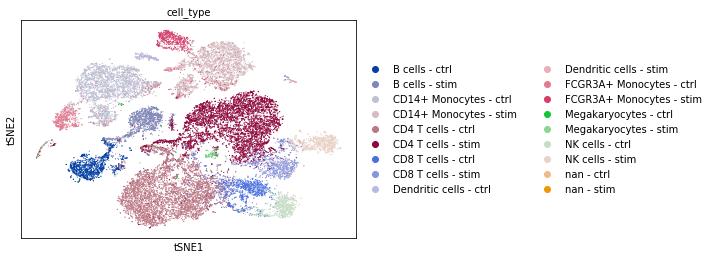

In [12]:
sc.pl.tsne(adata, color='cell_type')

### Gene counts

In [14]:
adata.var['n_umi'] = adata.X.sum(axis=0).A1

In [15]:
counts = adata.var.sort_values('n_umi', ascending=False)['n_umi'].values

In [16]:
umi_props = counts / counts.sum()

In [17]:
umi_prop_cumsum = np.cumsum(umi_props)

In [103]:
adata.var.shape

(35621, 6)

In [102]:
adata.var.sort_values('n_umi', ascending=False).head(5)

,gene_ids,n_umi,unnorm_var_rank,norm_var_rank,unnorm_mean_rank,norm_mean_rank
index,,,,,,
FTH1,ENSG00000167996,3101852.0,1.0,1.0,1.0,1.0
MALAT1,ENSG00000251562,2803678.0,5.0,3.0,7.0,3.0
B2M,ENSG00000166710,1736198.0,14347.0,45.0,7514.0,15170.0
FTL,ENSG00000087086,1445799.0,2.0,2.0,2.0,2.0
TMSB4X,ENSG00000205542,1317716.0,3.0,4.0,6.0,5.0


In [100]:
umi_prop_cumsum[:5]

array([0.06465616, 0.12309708, 0.15928704, 0.18942381, 0.21689078],
      dtype=float32)

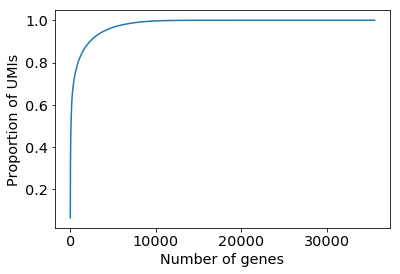

In [175]:
plt.plot(umi_prop_cumsum)
plt.xlabel('Number of genes');
plt.ylabel('Proportion of UMIs');

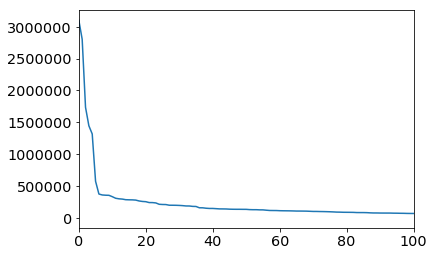

In [58]:
plt.plot(adata.var.sort_values('n_umi', ascending=False)['n_umi'].values)
plt.xlim(0, 100);

In [177]:
adata.obs.head(5)

,tsne1,tsne2,ind,stim,cluster,cell,multiplets,cell_type
index,,,,,,,,
AAACATACAATGCC-1,-4.277833,-19.294709,107,ctrl,5,CD4 T cells,doublet,CD4 T cells - ctrl
AAACATACATTTCC-1,-27.640373,14.966629,1016,ctrl,9,CD14+ Monocytes,singlet,CD14+ Monocytes - ctrl
AAACATACCAGAAA-1,-27.493646,28.924885,1256,ctrl,9,CD14+ Monocytes,singlet,CD14+ Monocytes - ctrl
AAACATACCAGCTA-1,-28.132584,24.925484,1256,ctrl,9,CD14+ Monocytes,doublet,CD14+ Monocytes - ctrl
AAACATACCATGCA-1,-10.468194,-5.984389,1488,ctrl,3,CD4 T cells,singlet,CD4 T cells - ctrl


In [ ]:
adata_norm

In [257]:
unnorm_diff_mean = (adata[adata.obs['cell_type'] == 'CD4 T cells - ctrl'].X.mean(axis=0) - \
    adata[adata.obs['cell_type'] == 'CD14+ Monocytes - ctrl'].X.mean(axis=0)).toarray()
norm_diff_mean = (adata_norm[adata_norm.obs['cell_type'] == 'CD4 T cells - ctrl'].X.mean(axis=0) - \
    adata_norm[adata_norm.obs['cell_type'] == 'CD14+ Monocytes - ctrl'].X.mean(axis=0)).toarray()

In [258]:
unnorm_diff_mean[np.isfinite(unnorm_diff_mean)].sum()

-1081.9539

In [259]:
norm_diff_mean[np.isfinite(norm_diff_mean)].sum()

0.00036621094

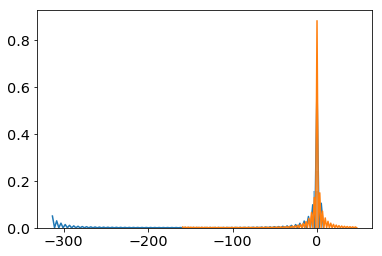

In [260]:
sns.distplot(unnorm_diff_mean[np.isfinite(unnorm_diff_mean)])
sns.distplot(norm_diff_mean[np.isfinite(norm_diff_mean)])

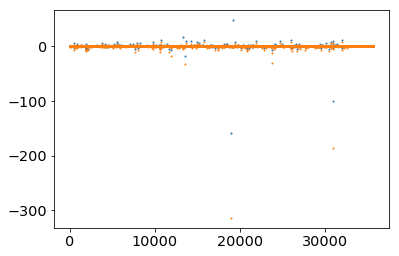

In [261]:
plt.scatter(np.arange(norm_diff_mean.shape[0]), norm_diff_mean, s=1)
plt.scatter(np.arange(unnorm_diff_mean.shape[0]), unnorm_diff_mean, s=1)

Text(0, 0.5, 'Change in expression')

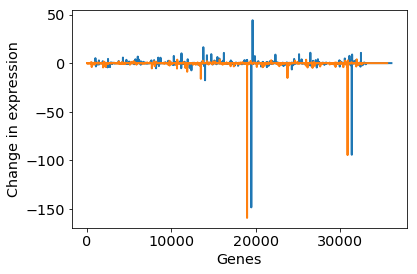

In [262]:
plt.plot(np.arange(norm_diff_mean.shape[0])+500, norm_diff_mean/norm_diff_mean.std(), lw=2)
plt.plot(np.arange(unnorm_diff_mean.shape[0]), unnorm_diff_mean/unnorm_diff_mean.std(), lw=2)
plt.xlabel('Genes')
plt.ylabel('Change in expression')
#plt.ylim(-10, 10)

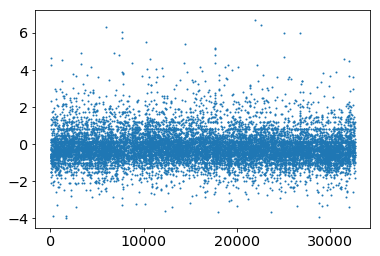

In [199]:
plt.scatter(np.arange(unnorm_diff_mean.shape[0]), unnorm_diff_mean.toarray(), s=1)

In [ ]:
plt.scatter(np.arange(unnorm_diff_mean.shape[0]), unnorm_diff_mean.toarray(), s=1)

In [ ]:
plt.scatter(np.arange(unnorm_diff_mean.shape[0]), unnorm_diff_mean.toarray(), s=1)

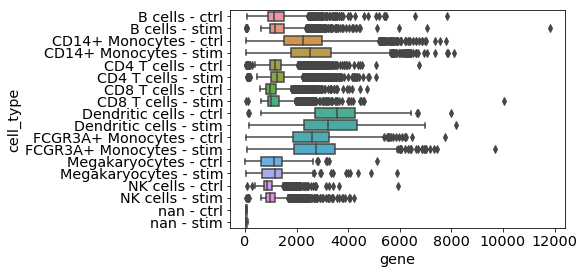

In [185]:
data = adata.obs.copy()
data['gene'] = adata.X.sum(axis=1)
sns.boxplot(x='gene', y='cell_type', data=data)

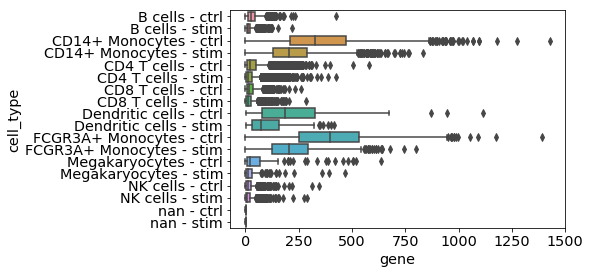

In [184]:
data = adata.obs.copy()
data['gene'] = adata[:, 'FTH1'].X
sns.boxplot(x='gene', y='cell_type', data=data)

### Normalize the data

In [22]:
adata_norm = adata.copy()
sc.pp.normalize_total(adata_norm)

In [23]:
adata.X = adata.X.toarray()
adata_norm.X = adata_norm.X.toarray()


### Increase in discrete counts with number of cells

In [15]:
def get_discrete_count_graph(gene):
    
    gene_counts = adata[:, gene].X#.toarray()
    discrete_counts = []
    num_trials = 1000
    for num_cells in num_cells_arr:
        trials = [np.unique(np.random.choice(gene_counts, replace=False, size=num_cells)).shape[0] for i in range(num_trials)]
        discrete_counts.append( sum(trials)/num_trials  )
        
    return discrete_counts

In [16]:
num_cells_arr = [100, 500, 1000, 2000, 3000, 5000, 10000, 20000]

In [17]:
malat1_counts = get_discrete_count_graph('MALAT1')
isg15_counts = get_discrete_count_graph('ISG15')
ccl8_counts = get_discrete_count_graph('CCL8')
cxcl10_counts = get_discrete_count_graph('CXCL10')
stat3_counts = get_discrete_count_graph('STAT3')

In [18]:
%matplotlib inline

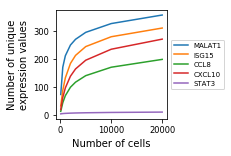

In [24]:
plt.figure(figsize=(2, 2))
params = {'legend.fontsize': 7,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.plot(num_cells_arr, malat1_counts)
plt.plot(num_cells_arr, isg15_counts)
plt.plot(num_cells_arr, ccl8_counts)
plt.plot(num_cells_arr, cxcl10_counts)
plt.plot(num_cells_arr, stat3_counts)
plt.legend(
    ['MALAT1', 'ISG15', 'CCL8', 'CXCL10', 'STAT3'], 
    loc='center left', 
    bbox_to_anchor=(1, 0.5))
plt.xlabel('Number of cells'); plt.ylabel('Number of unique\nexpression values')
plt.savefig('num_unique_vals.pdf', bbox_inches='tight')

### Number of nonzero entries as a function of number of cells

In [14]:
mat = adata.X.toarray()


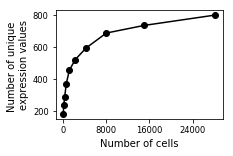

In [78]:
fig = plt.figure(figsize=(3, 2))
plt.plot(list(np.logspace(2, 4.45, 10)), num_unique, '-o', color='k')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(8000))
plt.xlabel('Number of cells')
plt.ylabel('Number of unique \nexpression values')
plt.savefig('all_ifn_unique_vals.pdf')
#plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))


In [44]:
num_unique

[197, 306, 494, 653]

In [46]:
num_unique = []
for num_cell in np.logspace(2, 4.45, 10):
    print(num_cell)
    
    subsample = mat[np.random.randint(0, mat.shape[0], size=int(num_cell)), ]
    subsample_nonzero = subsample[subsample != 0]
    num_unique.append(np.unique(subsample_nonzero).shape[0])
    
    del subsample
    del subsample_nonzero

100.0
187.16395863694845
350.3034741265335
655.6418494179792
1227.1252398511904
2296.736176338636
4298.662347082281
8045.546617235157
15058.363542798415
28183.82931264455
